In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from matplotlib.colors import ListedColormap, BoundaryNorm


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))
log_folder = '/home/uz22147/repos/downscaling-cgan'

from dsrnngan.plots import plot_precip
from dsrnngan.data import denormalise
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh



2023-01-27 11:43:00.786573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 11:43:00.786802: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
eval_df = pd.read_csv(os.path.join(log_folder, 'eval_validation.csv'))
eval_df.head()

,N,op,CRPS_no_pooling,CRPS_max_4,CRPS_max_16,CRPS_avg_4,CRPS_avg_16,mae,rmse,emmse,emmse_fcst,ralsd,corr,corr_ensemble,corr_fcst
0,160000,0.077346,0.121360,0.121360,0.121360,0.121360,0.121360,0.199353,0.870995,0.572712,0.570935,3.551033,0.071014,0.044637,0.021691
1,N,op,CRPS_no_pooling,CRPS_max_4,CRPS_max_16,CRPS_avg_4,CRPS_avg_16,mae,rmse,emmse,emmse_fcst,ralsd,corr,corr_ensemble,corr_fcst
2,160000,0.057789,0.051085,0.051085,0.051085,0.051085,0.051085,0.089386,0.643976,0.380141,0.376571,4.135722,0.110858,0.034460,0.029137
3,N,op,CRPS_no_pooling,CRPS_max_4,CRPS_max_16,CRPS_avg_4,CRPS_avg_16,mae,rmse,emmse,emmse_fcst,ralsd,corr,corr_ensemble,corr_fcst
4,160000,0.048508,0.098110,0.098110,0.098110,0.098110,0.098110,0.202153,1.158686,0.717556,0.724488,5.040466,0.069432,0.100051,0.079051


In [5]:
with np.load(os.path.join(log_folder, 'ranks-160000.npz')) as ranks_data:
    ranks_dict = dict(ranks_data.items())

with open(os.path.join(log_folder, 'other_metrics-160000.pkl'), 'rb') as ifh:
    other_metrics = pickle.load(ifh)


In [3]:
with open(os.path.join(log_folder, 'arrays-160000.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)
    
truth_array = arrays['truth']
samples_gen_array = arrays['samples_gen']
fcst_array = arrays['fcst_array']
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
dates = arrays['dates']
hours = arrays['hours']

(n_samples, width, height, ensemble_size) = samples_gen_array.shape

## This is needed until code is fixed

for n in range(fcst_array.shape[0]):
    fcst_array[n,:,:] = denormalise(fcst_array[n,:,:])

In [9]:
# Summary statistics
array_dict = {'IFS': fcst_array, 'iMERG': truth_array, 'cGAN': samples_gen_array}
for k, v in array_dict.items():
    
    print('*'*10)
    print(k)
    print('Mean = ', v.mean())
    print('Max = ', v.max())
    print('Min = ', v.min())
    print('Median: ', np.median(v))

**********
IFS
Mean =  0.08995985738146559
Max =  44.96231488883496
Min =  0.0
Median:  0.0
**********
iMERG
Mean =  0.108105086
Max =  111.52867
Min =  0.0
Median:  0.00058548525
**********
cGAN
Mean =  0.12237558
Max =  500.001
Min =  0.0
Median:  0.0007104096


In [49]:
# Find dry and rainy days in sampled dataset
means = [(n, truth_array[n,:,:].mean()) for n in range(n_samples)]
sorted_means = sorted(means, key=lambda x: x[1])

n_extreme_days = 10
wet_day_indexes = [item[0] for item in sorted_means[-10:]]
dry_day_indexes = [item[0] for item in sorted_means[:10]]

100%|██████████| 2/2 [00:00<00:00, 30.69it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


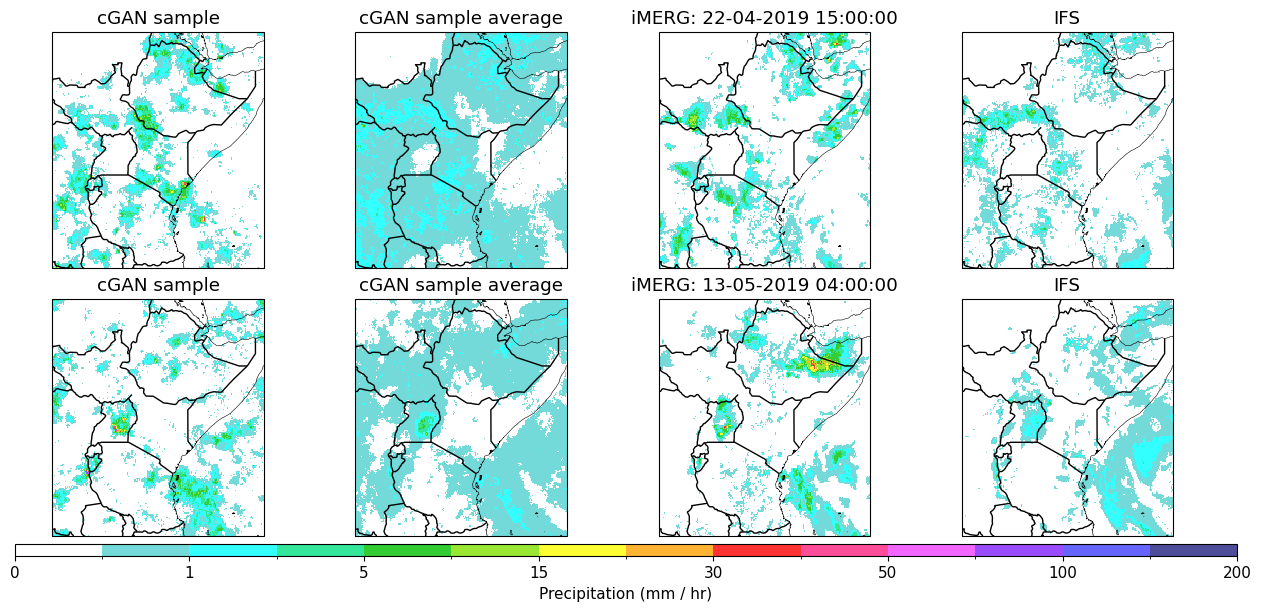

In [179]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

tp_index = data.all_ifs_fields.index('tp')

# plot configurations
levels = [0, 0.1, 1, 2.5, 5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200] # in units of log10
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(levels)-1], 'precipitation')
precip_norm = BoundaryNorm(levels, precip_cmap.N)
plt.rcParams.update({'font.size': 11})
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)

indexes = wet_day_indexes[3:5]
num_cols = 5
num_samples = len(indexes)
num_rows = num_samples
# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows + 1, num_cols, figure=fig, 
                       width_ratios=[1]*(num_cols - 1) + [0.05],
                       height_ratios=[1]*(num_rows) + [0.05],
                       wspace=0.005)                      
for n in tqdm(range(len(indexes))):

    ix = indexes[n]
    img_gens = samples_gen_array[ix, :,:,:]
    truth = truth_array[ix,:,:]
    fcst = fcst_array[ix,:,:]
    date = dates[ix]
    hour = hours[ix]
    avg_img_gens = img_gens.mean(axis=-1)
    date_str = date[0].strftime('%d-%m-%Y') + f' {hour[0]:02d}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[:,:,0], 'title': 'cGAN sample'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN sample average'},
                   'imerg' : {'title': f"iMERG: {date_str}", 'data': truth},
                   'ifs': {'data': fcst, 'title': 'IFS'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[n, col], projection = ccrs.PlateCarree())
        # im = plot_precip(np_array=np.log(val['data']), ax=ax)
        ax.coastlines(resolution='10m', color='black', linewidth=0.4)
        im = ax.imshow(val['data'],
                interpolation='nearest',
                norm=precip_norm,
                cmap=precip_cmap,
                origin='lower',
                extent=[min(DEFAULT_LONGITUDE_RANGE), max(DEFAULT_LONGITUDE_RANGE), 
                  min(DEFAULT_LATITUDE_RANGE), max(DEFAULT_LATITUDE_RANGE)],
                transform=ccrs.PlateCarree(),
                alpha=0.8)
        ax.add_feature(cfeature.BORDERS)
        ax.set_title(val['title'])
        
# precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
# precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[-1, :])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                  )

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_xlabel("Precipitation (mm / hr)", loc='center')


plt.savefig('cGAN_samples_IFS.eps', format='eps')

In [14]:
rapsd_dict = {k: v for k, v in other_metrics.items() if k.startswith('rapsd')}
crps_dict = {k: v for k, v in other_metrics.items() if k.startswith('CRPS')}

In [11]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE

special_areas = {'lake_victoria': {'lat_range': [-3,1], 'lon_range': [31, 35]},
                 'nairobi': {'lat_range': [-1.5,-1], 'lon_range': [36.5, 37]},
                 'mombasa (coastal)': {'lat_range': [-4.1,-3.9], 'lon_range': [39.5, 39.8]},
                 'addis ababa': {'lat_range': [8.8, 9.1], 'lon_range': [38.5, 38.9]},
                 'bale_mountains': {'lat_range': [6.6, 7.0], 'lon_range': [39.3, 40.2]}}

lat_range = [np.round(item, 1) for item in DEFAULT_LATITUDE_RANGE]
lon_range = [np.round(item, 1) for item in DEFAULT_LONGITUDE_RANGE]

for k, v in special_areas.items():
    special_areas[k]['lat_index_range'] = [lat_range.index(v['lat_range'][0]), lat_range.index(v['lat_range'][1])]
    special_areas[k]['lon_index_range'] = [lon_range.index(v['lon_range'][0]), lon_range.index(v['lon_range'][1])]

## Rank histogram

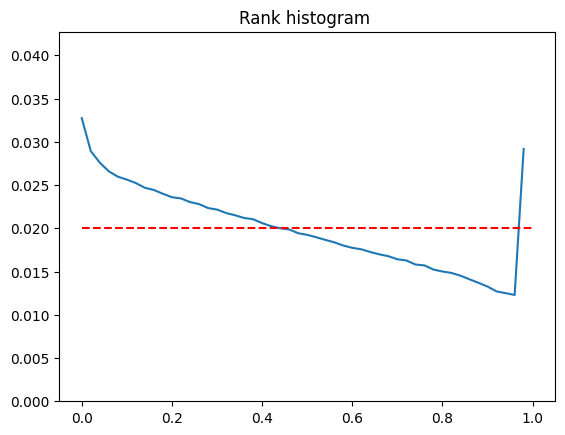

In [10]:
rng = np.random.default_rng()
noise_factor = 1e-6
n_samples = 100

temp_truth = np.repeat(truth_array[:n_samples, :, : ,None].copy(), samples_gen_array.shape[-1], axis=-1)
temp_samples = samples_gen_array[:n_samples, :, :, :].copy()

temp_truth += rng.random(size=temp_truth.shape, dtype=np.float32)*noise_factor
temp_samples += rng.random(size=temp_samples.shape, dtype=np.float32)*noise_factor

ranks = np.sum(temp_truth > temp_samples, axis=-1)

fig, ax = plt.subplots(1,1)
(h, _) = np.histogram(ranks.flatten(), bins=50)
h = h / h.sum()
ax.plot(h)
ax.hlines(1/50, 0, 50, linestyles='dashed', colors=['r'])
ax.set_xticks(np.arange(0, 51, 10))
ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
ax.set_ylim([0, max(h)+0.01])
ax.set_title('Rank histogram ')
plt.savefig('cgan_metrics/rank_hist.png')

# RAPSD

In [4]:
from dsrnngan.rapsd import rapsd

rapsd_truth = []
rapsd_pred = []
rapsd_fcst = []
rapsd_ensmean = []  

for n in tqdm(range(n_samples)):
        fft_freq_pred = rapsd(truth_array[n,:,:], fft_method=np.fft)
        rapsd_truth.append(fft_freq_pred)
        
        fft_freq_pred = rapsd(samples_gen_array[n,:,:,0], fft_method=np.fft)
        rapsd_pred.append(fft_freq_pred)

        fft_freq_fcst = rapsd(fcst_array[n, :, :], fft_method=np.fft)
        rapsd_fcst.append(fft_freq_fcst)
        
        fft_freq_ensmean = rapsd(ensmean_array[n, :, :], fft_method=np.fft)
        rapsd_ensmean.append(fft_freq_ensmean)

rapsd_truth = np.mean(np.stack(rapsd_truth, axis=-1), axis=-1)
rapsd_pred = np.mean(np.stack(rapsd_pred, axis=-1), axis=-1)
rapsd_fcst = np.mean(np.stack(rapsd_fcst, axis=-1), axis=-1)
rapsd_ensmean = np.mean(np.stack(rapsd_ensmean, axis=-1), axis=-1)

100%|██████████| 1000/1000 [00:16<00:00, 62.49it/s]


/tmp/ipykernel_206/1709733592.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 200])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


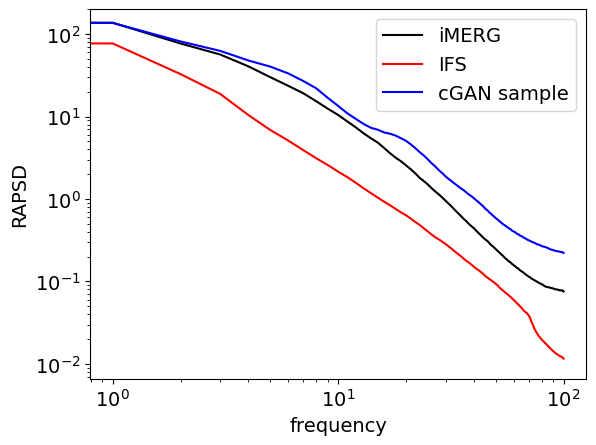

In [6]:
fig, ax = plt.subplots(1,1)

ax.plot(rapsd_truth, label='iMERG', color='k')
ax.plot(rapsd_fcst, 'r', label='IFS')
ax.plot(rapsd_pred, 'b', label='cGAN sample') # Single member of ensemble
plt.xscale('log')
plt.yscale('log')
ax.set_ylim([0, 200])
ax.set_ylabel('RAPSD')
ax.set_xlabel('frequency')
ax.legend()
plt.rcParams.update({'font.size': 14})
plt.savefig('cgan_metrics/rapds.eps', format='eps')

## Histograms

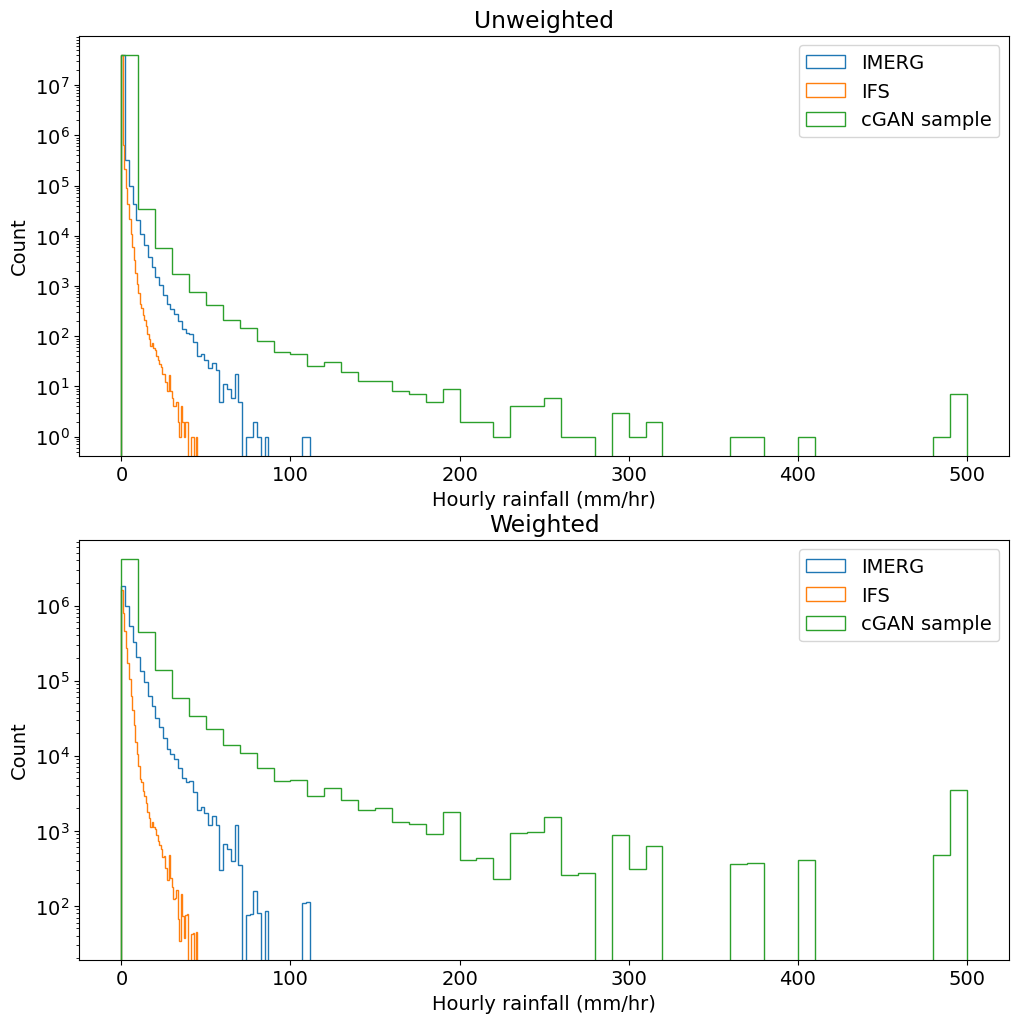

In [36]:
# quantile histograms

fig, axs = plt.subplots(2,1, figsize=(12,12))
num_bins = 50
(bin_count, bin_values) = np.histogram(truth_array.flatten(), bins=num_bins)

axs[0].hist(truth_array.flatten(), bins=num_bins, histtype='step', label='IMERG')
axs[0].hist(fcst_array.flatten(), bins=num_bins, histtype='step', label='IFS')
axs[0].hist(samples_gen_array[:,:,:,0].flatten(), bins=num_bins, histtype='step', label='cGAN sample')
axs[0].set_title('Unweighted')

axs[1].hist(truth_array.flatten(), bins=num_bins, histtype='step',weights=truth_array.flatten(), label='IMERG')
axs[1].hist(fcst_array.flatten(), bins=num_bins, histtype='step', weights=fcst_array.flatten(), label='IFS')
axs[1].hist(samples_gen_array[:,:,:,0].flatten(), bins=num_bins, histtype='step', weights=samples_gen_array[:,:,:,0].flatten(), label='cGAN sample')#
axs[1].set_title('Weighted')

for ax in axs:
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Hourly rainfall (mm/hr)')
    ax.set_ylabel('Count')


## Quantiles

In [8]:
# quantile_boundaries = np.arange(0, 1+1/n_quantiles, 1/n_quantiles) # Expressed as fractions, e.g. 0.5 = 50th percentile

# truth_quantiles = np.quantile(truth_array_thresholded, quantile_boundaries)
# sample_quantiles = np.quantile(sample_quantiles_thresholded, quantile_boundaries)
# fcst_quantiles = np.quantile(fcst_array_thresholded, quantile_boundaries)

number_in_top_range = 1000
quantile_boundaries = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] + list(np.linspace(0.9, 0.9999, number_in_top_range))
truth_quantiles = np.quantile(truth_array, quantile_boundaries)
sample_quantiles = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries)
print('Number data points per quantile in top range: ', 0.1*len(truth_array.flatten()) / number_in_top_range)
print('percentile steps in top range: ', 10 / number_in_top_range)

Number data points per quantile in top range:  4020.0
percentile steps in top range:  0.01


In [160]:

# Find quantile for imerg and ifs that exceeds threshold
threshold = 1
imerg_lowest_quantile = min([n for n in range(len(truth_quantiles)) if truth_quantiles[n] > 0.1])
fcst_lowest_quantile = min([n for n in range(len(fcst_quantiles)) if fcst_quantiles[n] > 0.1])

min_quantile = min(imerg_lowest_quantile, fcst_lowest_quantile)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


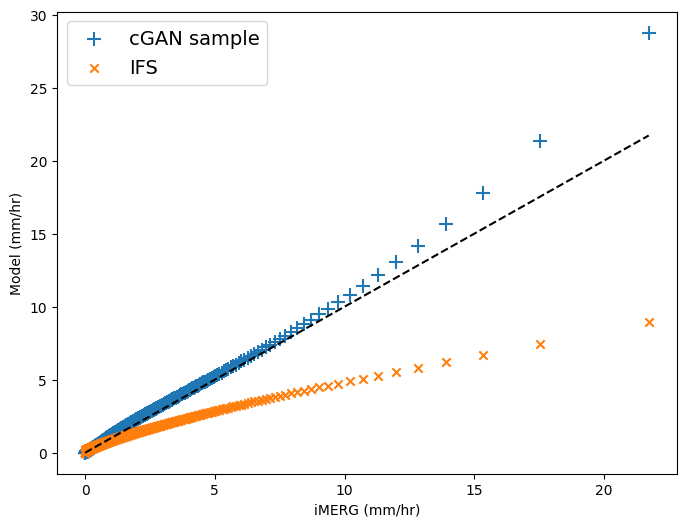

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

max_fcst_val = max(max(sample_quantiles), max(fcst_quantiles))
max_truth_val = max(truth_quantiles)
ax.scatter(truth_quantiles, sample_quantiles, marker='+', label='cGAN sample', s=100)
ax.scatter(truth_quantiles, fcst_quantiles, marker='x', label='IFS')
# plt.xscale('log')
# plt.yscale('log')
ax.plot(np.linspace(0, max_truth_val, 100), np.linspace(0, max_truth_val, 100), 'k--')
ax.set_xlabel('iMERG (mm/hr)')
ax.set_ylabel('Model (mm/hr)')

plt.rcParams.update({'font.size': 14})
ax.legend()
plt.savefig('cgan_metrics/quantiles_total.eps', format='eps')

In [10]:
# Quantiles for different areas

fig, ax = plt.subplots(max(2, len(special_areas)),1, figsize=(6, 16))

for n, (area, area_range) in enumerate(special_areas.items()):


    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    truth_quantiles = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    sample_quantiles = np.quantile(samples_gen_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1], 0], quantile_boundaries)
    fcst_quantiles = np.quantile(fcst_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    
    max_val = max(max(truth_quantiles), max(sample_quantiles), max(fcst_quantiles))
    
    ax[n].scatter(truth_quantiles, sample_quantiles, marker='+', label='cgan')
    ax[n].scatter(truth_quantiles, fcst_quantiles, marker='x', label='fcst')
    ax[n].plot(np.arange(0,max_val, 0.01), np.arange(0,max_val, 0.01), 'k--')
    ax[n].set_xlabel('truth')
    ax[n].set_ylabel('model')
    ax[n].set_title(area)
    ax[n].set_xlim([-0.01, max_val + 0.01])
    ax[n].set_ylim([-0.01, max_val + 0.01])
    ax[n].legend()
    
fig.tight_layout(pad=2.0)
plt.savefig('cgan_metrics/quantiles_area.png')

NameError: name 'special_areas' is not defined

## Grid metrics

In [120]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE


In [131]:
def plot_contourf_2(ax, data, title, value_range=None, lon_range=DEFAULT_LONGITUDE_RANGE, lat_range=DEFAULT_LATITUDE_RANGE,
                  cmap='Reds'):
    
    if value_range:
        im = ax.contourf(lon_range, lat_range, data, transform=ccrs.PlateCarree(),
                            cmap=cmap, 
                            levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                            extend='both')
    else:
        print(len(lon_range))
        print(len(lat_range))
        im = ax.contourf(lon_range, lat_range, data, transform=ccrs.PlateCarree(),
                    cmap=cmap, 
                    extend='both')

    ax.coastlines(resolution='10m', color='black', linewidth=0.4)
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(title)
    
    return im

In [126]:
# RMSE
rmse_dict = {'single_sample_rmse': np.sqrt(np.mean(np.square(truth_array - samples_gen_array[:,:,:,0]), axis=0)),
            'ensmean_rmse' : np.sqrt(np.mean(np.square(truth_array - np.mean(samples_gen_array, axis=-1)), axis=0)),
            'fcst_rmse' : np.sqrt(np.mean(np.square(truth_array - fcst_array), axis=0))}

# Standard deviation of truth
truth_std = np.std(truth_array, axis=0)



TypeError: Length of x (250) must match number of columns in z (200)

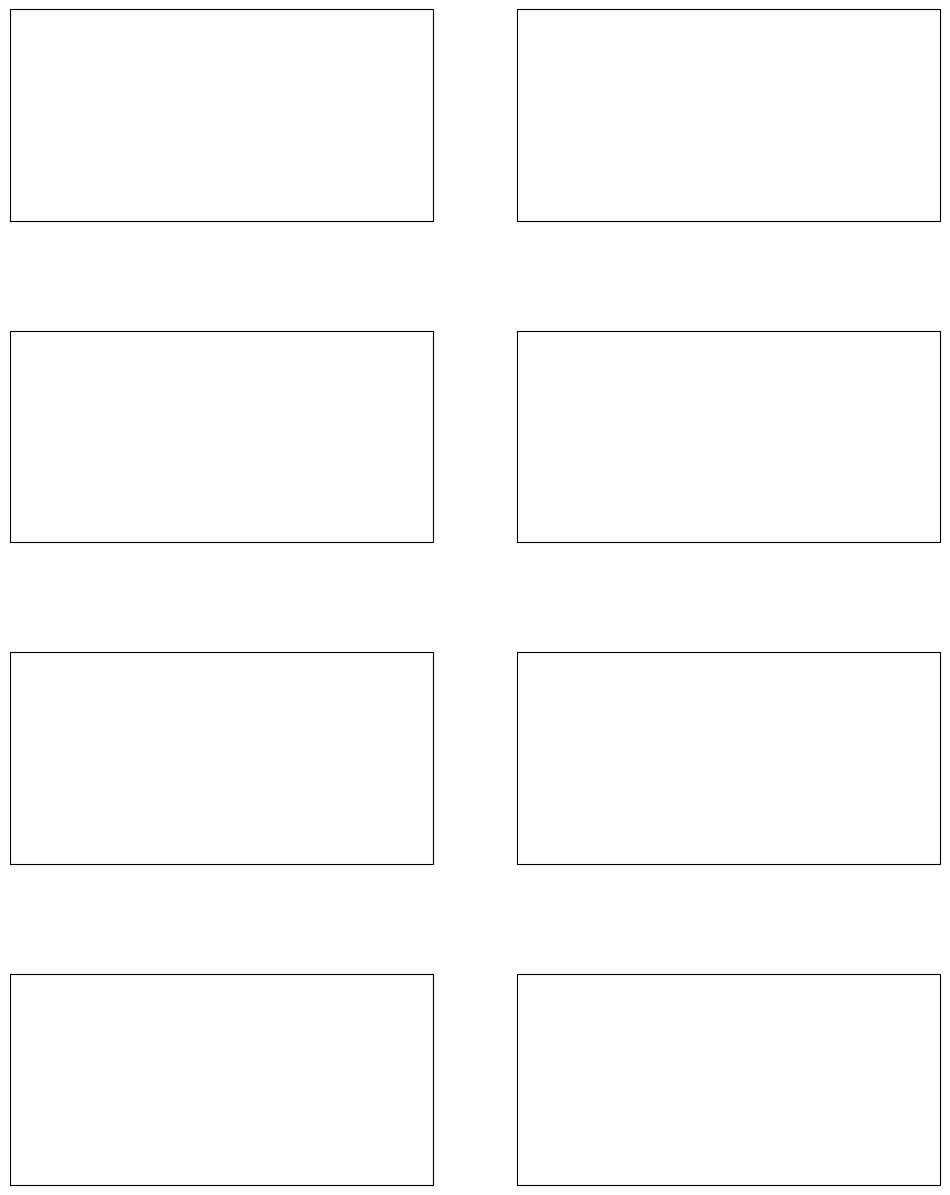

In [132]:
# RMSE
fig, ax = plt.subplots(len(rmse_dict.keys())+1,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))

max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

value_range_2 = list(np.arange(0, 5, 5 / 50))

for n, (k, v) in enumerate(rmse_dict.items()):
    
    im = plot_contourf_2(ax[n,0], v, title=k, value_range=value_range)
    plt.colorbar(im, ax=ax[n,0])
    ax[n,0].set_title(k)
    im2 = plot_contourf_2(ax[n,1], v / truth_std, title=k + ' / truth_std', value_range=value_range_2 )
    plt.colorbar(im2, ax=ax[n,1])

im = plot_contourf_2(ax[n+1,0], truth_std, title='truth_std')
plt.colorbar(im, ax=ax[n+1,0])

plt.savefig('cgan_metrics/rmse.png')


In [130]:
v.shape

(201, 200)

In [122]:
# bias
bias_dict = {'single_sample_bias': np.mean(samples_gen_array[:,:,:,0] - truth_array, axis=0),
            'ensmean_bias' : np.mean(ensmean_array - truth_array, axis=0),
            'fcst_bias' : np.mean(fcst_array - truth_array, axis=0)}

# average of truth for comparison
truth_avg = np.mean(truth_array, axis=0)

TypeError: Length of x (250) must match number of columns in z (200)

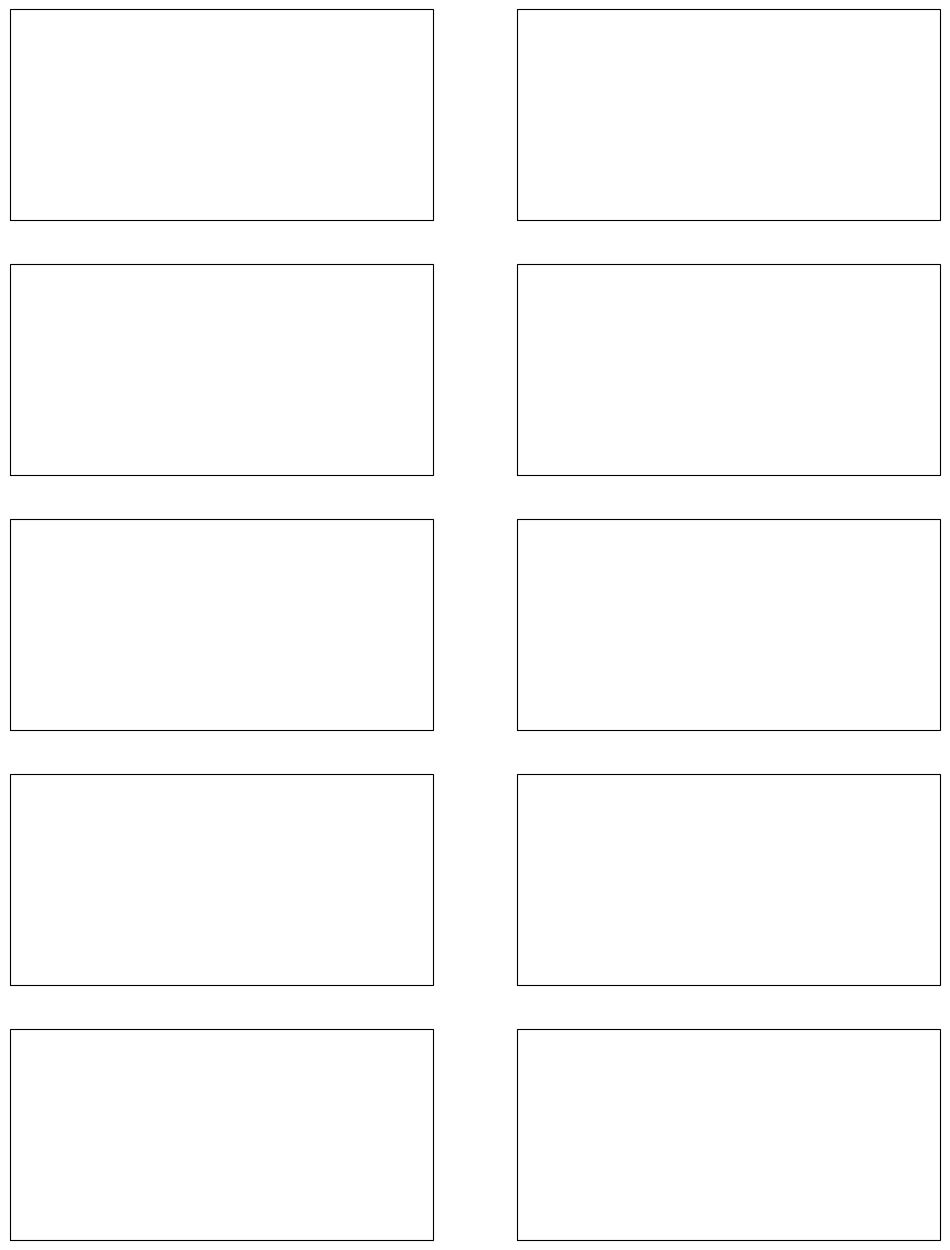

In [123]:

fig, ax = plt.subplots(len(bias_dict.keys())+2,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))

max_bias_val = max([v.max() for v in bias_dict.values()])

for n, (k,v) in enumerate(bias_dict.items()):


    # value_range = list(np.arange(-0.5, 0.5, 0.01))
    value_range = None

    im = plot_contourf(ax[n,0], v, title=k, cmap='RdBu', value_range=value_range)
    plt.colorbar(im, ax=ax[n,0])
    
    im = plot_contourf(ax[n,1], 100* v / truth_avg, title=f'100 * {k} / truth_avg', value_range=list(np.arange(-200, 200, 400 / 50)),
                       cmap='RdBu')
    plt.colorbar(im, ax=ax[n,1])
    
im = plot_contourf(ax[n+1,0], truth_avg, title='truth_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+1,0])

im = plot_contourf(ax[n+1,1], np.mean(np.mean(samples_gen_array, axis=-1), axis=0), title='samples_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+1,1])

im = plot_contourf(ax[n+2,0], np.mean(fcst_array, axis=0), title='fcst_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+2,0])

im = plot_contourf(ax[n+2,1], np.mean(fcst_array, axis=0), title='', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+2,1])

plt.savefig('cgan_metrics/bias.png')


In [114]:
v.shape

(201, 200)

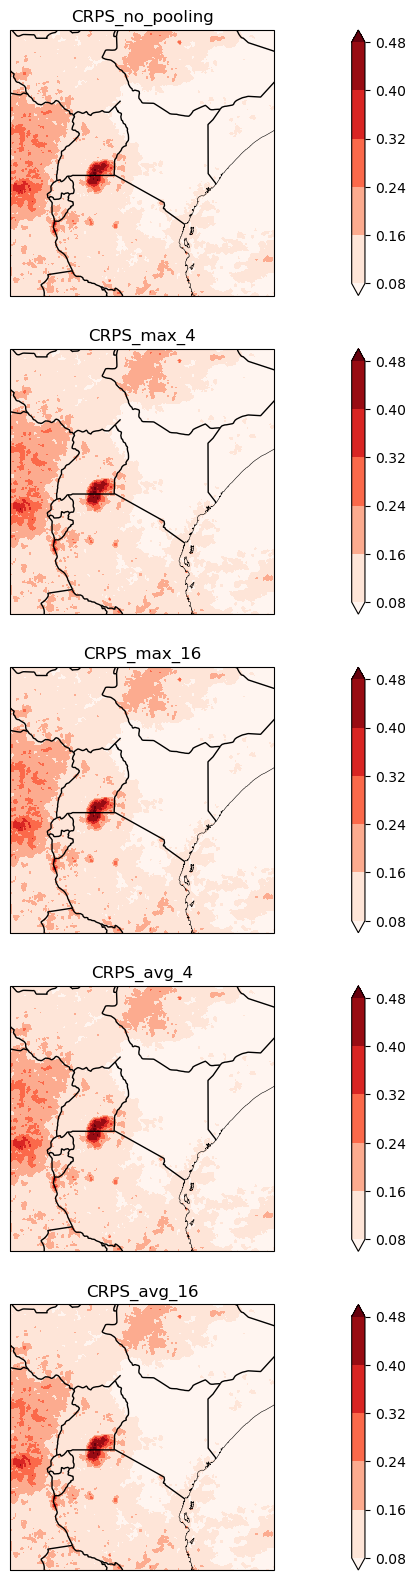

In [173]:
fig, ax = plt.subplots(len(crps_dict.keys()), 1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(20, 20))

for n, k in enumerate(crps_dict.keys()):

    max_level = 10
    value_range = list(np.arange(0, max_level, max_level / 50))

    im = ax[n].contourf(default_longitude_range, default_latitude_range, crps_dict[k], transform=ccrs.PlateCarree(),
                        cmap='Reds', 
                        # levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                        extend='both')

    ax[n].coastlines(resolution='10m', color='black', linewidth=0.4)
    ax[n].add_feature(cfeature.BORDERS)
    ax[n].set_title(k)
    plt.colorbar(im, ax=ax[n])
plt.savefig('cgan_metrics/crps.png')


## Scatter plots

In [128]:
import random

truth = arrays['truth']
samples_gen = arrays['samples_gen']

(num_images, height, width, ensemble_size) = samples_gen.shape

stacked_truth = np.repeat(truth[:, :, :, np.newaxis], ensemble_size, axis=3)

In [129]:
indexes = random.sample(range(len(samples_gen.flatten())), 10000)

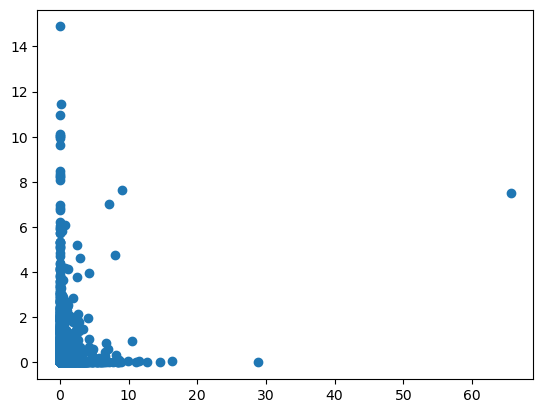

In [130]:
plt.scatter(samples_gen.flatten()[indexes], stacked_truth.flatten()[indexes])

# Fractional skill score

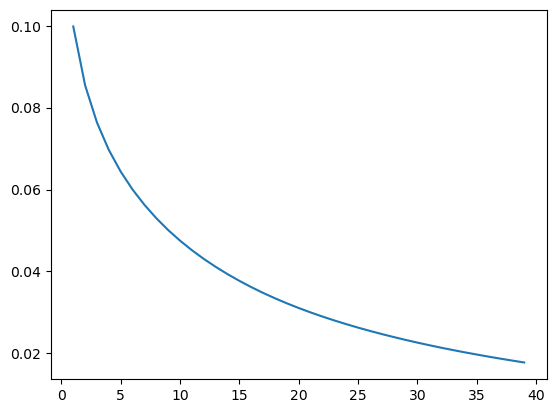

In [108]:
#evaluate percentage of rainy pixels based on threshold
daily_thresholds = range(1,40)
num_rainy_pixels = []
for thr in daily_thresholds:
    num_rainy_pixels.append((truth_array >= thr/24.0).astype(np.single).mean())
plt.plot(daily_thresholds, num_rainy_pixels)

In [4]:
from dsrnngan.scoring import fss
from tqdm import tqdm


window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200]
daily_thresholds = [1, 5, 20, 30, 50] # 1mm/day = drizzle, 50 mm/day = extreme

fss_cgan = []
fss_fcst = []
fss_ensmean = []

for thr in daily_thresholds:

    tmp_fss_cgan = []
    tmp_fss_fcst = []
    tmp_fss_ensmean = []

    for w in tqdm(window_sizes):
        
        tmp_fss_cgan.append(fss(truth_array, samples_gen_array, w, thr/24.0, mode='constant'))
        tmp_fss_fcst.append(fss(truth_array, fcst_array, w, thr/24.0, mode='constant'))
        tmp_fss_ensmean.append(fss(truth_array, ensmean_array, w, thr/24.0, mode='constant'))
    
    fss_cgan.append(tmp_fss_cgan)
    fss_fcst.append(tmp_fss_fcst)
    fss_ensmean.append(tmp_fss_ensmean)

100%|██████████| 17/17 [05:39<00:00, 19.98s/it]


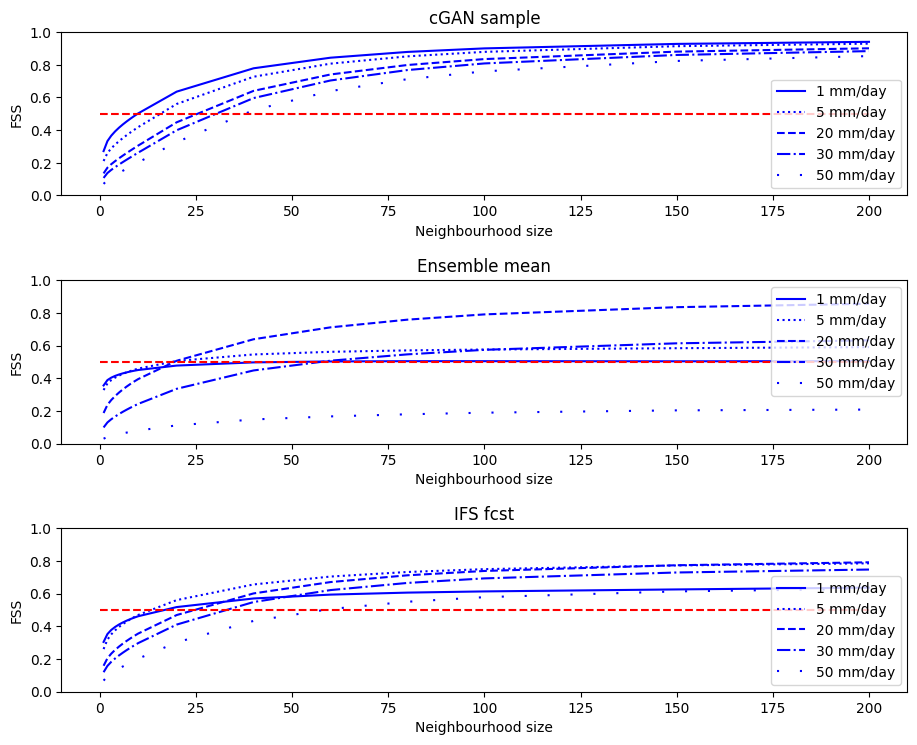

In [7]:
fig, axs = plt.subplots(3, 1, figsize = (10, 8))
fig.tight_layout(pad=4.0)
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10))]

for n, thr in enumerate(daily_thresholds):
    
    axs[0].plot(window_sizes, [item for item in fss_cgan[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    axs[1].plot(window_sizes, [item for item in fss_ensmean[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    axs[2].plot(window_sizes, [item for item in fss_fcst[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])

    axs[0].set_title('cGAN sample')
    axs[1].set_title('Ensemble mean')
    axs[2].set_title('IFS fcst')

for ax in axs:    
    ax.hlines(0.5, 0, max(window_sizes), linestyles='dashed', colors=['r'])
    ax.set_ylim(0,1)
    ax.set_xlabel('Neighbourhood size')
    ax.set_ylabel('FSS')
    ax.legend()
    
plt.savefig('cgan_metrics/fractional_skill_score.png')




In [177]:
!zip -r cgan_metrics.zip cgan_metrics

updating: cgan_metrics/ (stored 0%)
updating: cgan_metrics/fractional_skill_score.png (deflated 8%)
updating: cgan_metrics/bias.png (deflated 2%)
updating: cgan_metrics/quantiles_total.png (deflated 15%)
updating: cgan_metrics/rank_hist.png (deflated 16%)
updating: cgan_metrics/quantiles_area.png (deflated 21%)
updating: cgan_metrics/rmse.png (deflated 2%)
updating: cgan_metrics/rapds.png (deflated 6%)
updating: cgan_metrics/crps.png (deflated 10%)
  adding: cgan_metrics/cGAN_samples_IFS.png (deflated 6%)
